In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
A=np.loadtxt("Espectro.dat")

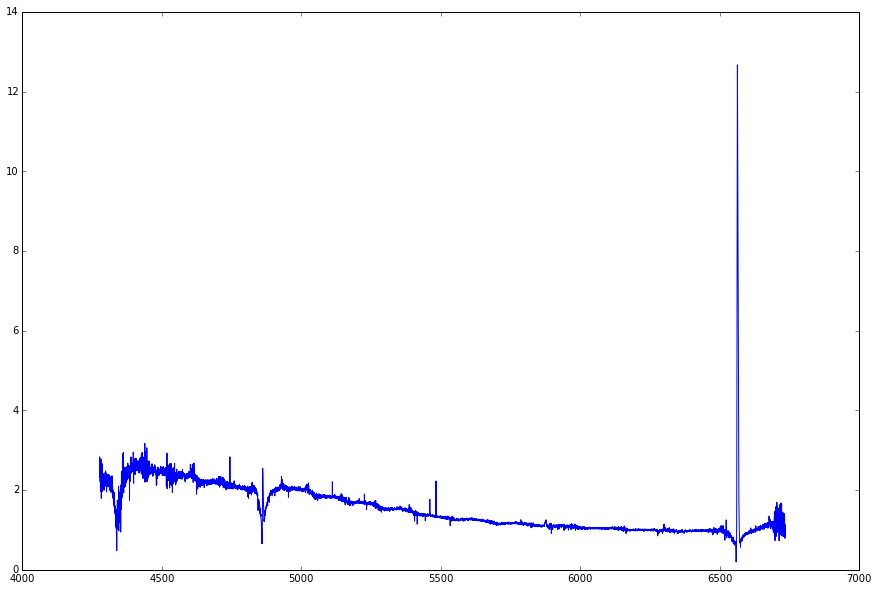

In [191]:
plt.figure(figsize=(15,10))
plt.plot(A[:,0],A[:,1])

In [198]:
l=A[:,0]
x=A[:,1]
lin=4430
lfi=6200
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
x=np.concatenate((x[l<4820],x[l>5050]))
l=np.concatenate((l[l<4820],l[l>5050]))

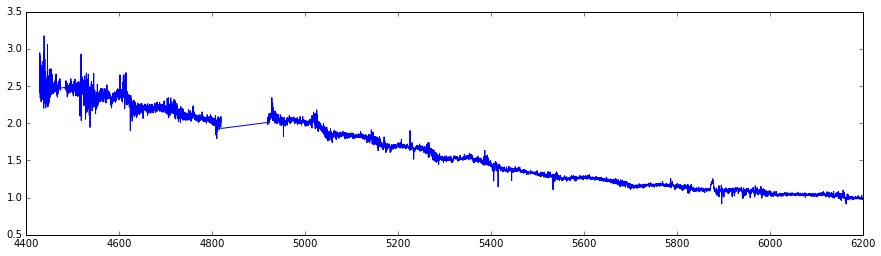

In [312]:
plt.figure(figsize=(15,4))
plt.plot(l,x)


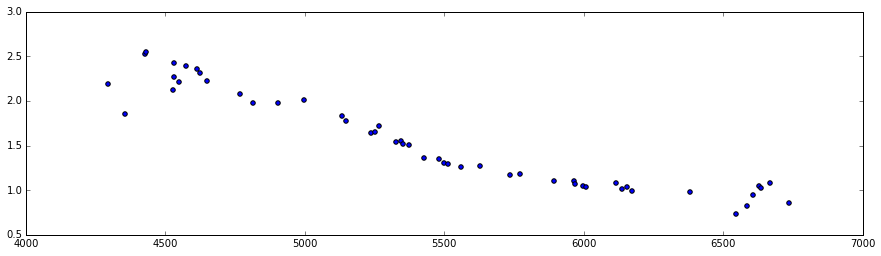

In [227]:
prob=1/1000.
lottery=np.random.choice([0, 1], size=(x.size,), p=[1-prob, prob])
llot=lottery.astype(bool)
plt.figure(figsize=(15,4))
plt.scatter(l[llot],x[llot])

In [138]:
lottery.sum()/(1.*x.size)

0.0097084226248457684

In [3]:
def bbody(l,T,A,B):
    l=l/1.e10
    c2=1.439e-2
    A=A*1e-30
    return (A/l**5)*(1/(np.exp(c2/(l*T))-1))+B


(4000, 6000)

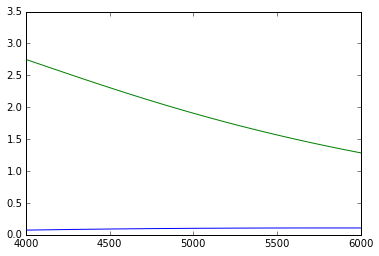

In [114]:
ll=np.linspace(1000,20000,1000)
plt.plot(ll,bbody(ll,5000.,1.))
plt.plot(ll,bbody(ll,10000.,1.))
plt.xlim(4000,6000)

In [5]:
from scipy.optimize import curve_fit

In [199]:
miter=1000
prob=1/1000.
ptemp=np.zeros(miter)
pA=np.zeros(miter)
for i in range(miter):
    lottery=np.random.choice([0, 1], size=(x.size,), p=[1-prob, prob])
    llot=lottery.astype(bool)
    par,pconv = curve_fit(bbody, l[llot], x[llot],p0=[10000.,1.])
    ptemp[i]=par[0]
    pA[i]=par[1]

In [201]:
np.std(ptemp)*100/np.mean(ptemp)

16.061347425053704

In [202]:
np.std(pA)*100/np.mean(pA)

130.90265512269721

In [204]:
np.mean(ptemp)

11531.608363362848

In [205]:
np.mean(pA)

0.87540940958055147

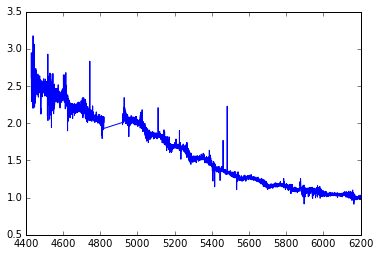

In [307]:
l=A[:,0]
x=A[:,1]
lin=4430
lfi=6200
lwin=4820
#lwfi=4920
lwfi=4920
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
plt.plot(l,x)

In [310]:
miter=1000
prob=1/1000.
ptemp=np.zeros(miter)
pA=np.zeros(miter)
for i in range(miter):
    lottery=np.random.choice([0, 1], size=(x.size,), p=[1-prob, prob])
    llot=lottery.astype(bool)
    par,pconv = curve_fit(bbody, l[llot], x[llot],p0=[10000.,1.])
    ptemp[i]=par[0]
    pA[i]=par[1]
print "Teff,RErrT,RErrA=",ptemp.mean(),np.std(ptemp)*100/np.mean(ptemp),np.std(pA)*100/np.mean(pA)

Teff,RErrT,RErrA= 17133.6509477 7.70721869236 14.4825476673


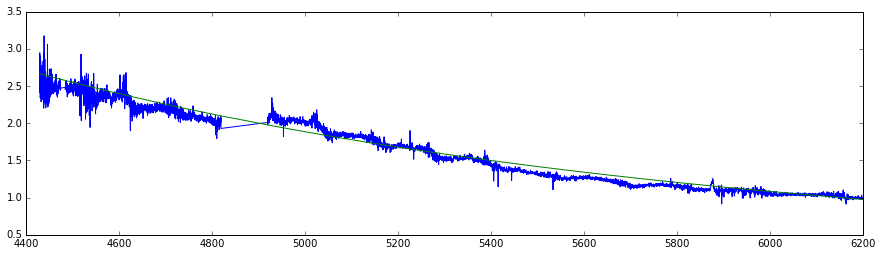

In [311]:
plt.figure(figsize=(15,4))
plt.plot(l,x)
plt.plot(l,bbody(l,ptemp.mean(),pA.mean()))
dd=6200
#plt.xlim(dd,dd+100)

(5480, 5490)

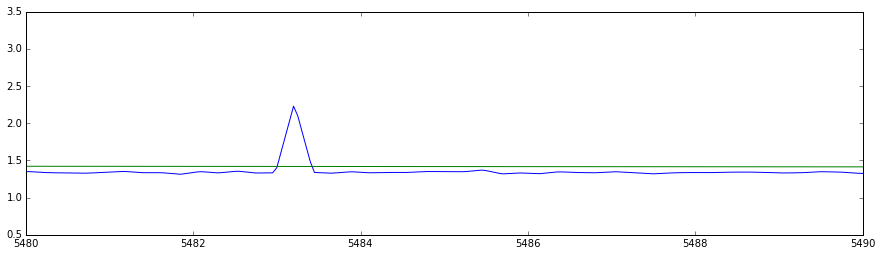

In [284]:
plt.figure(figsize=(15,4))
plt.plot(l,x)
plt.plot(l,bbody(l,ptemp.mean(),pA.mean()))
dd=5480
plt.xlim(dd,dd+10)

Teff,Aeff,Beff,RErrT,RErrA= 9709.44991383 1.68028516078 -0.97204325775 4.57736918226 19.5841222177


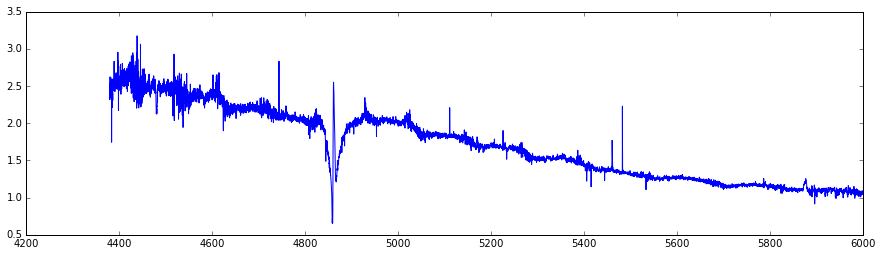

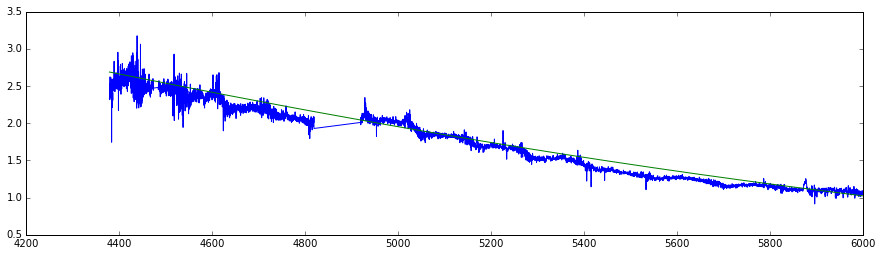

In [8]:
l=A[:,0]
x=A[:,1]
lin=4380
lfi=6000
lwin=4820
#lwfi=4920
lwfi=4920
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
plt.figure(figsize=(15,4))
plt.plot(l,x)
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4475
#lwfi=490
lwfi=4485
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4744
#lwfi=490
lwfi=4746
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5111
#lwfi=490
lwfi=5112
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5460
#lwfi=490
lwfi=5462
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5482
#lwfi=490
lwfi=5484
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))

miter=100000
prob=1/100.
ptemp=np.zeros(miter)
pA=np.zeros(miter)
pB=np.zeros(miter)
for i in range(miter):
    lottery=np.random.choice([0, 1], size=(x.size,), p=[1-prob, prob])
    llot=lottery.astype(bool)
    par,pconv = curve_fit(bbody, l[llot], x[llot],p0=[10000.,1.,1.])
    ptemp[i]=par[0]
    pA[i]=par[1]
    pB[i]=par[2]
plt.figure(figsize=(15,4))
plt.plot(l,x)
plt.plot(l,bbody(l,ptemp.mean(),pA.mean(),pB.mean()))
Teff=ptemp.mean()
Aeff=pA.mean()
Beff=pB.mean()
print "Teff,Aeff,Beff,RErrT,RErrA=",ptemp.mean(),pA.mean(),pB.mean(),np.std(ptemp)*100/np.mean(ptemp),np.std(pA)*100/np.mean(pA)


In [526]:
plt.plot?

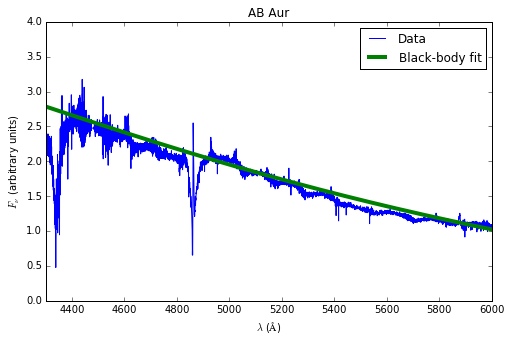

In [550]:
l=A[:,0]
x=A[:,1]
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4475
#lwfi=490
lwfi=4485
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4744
#lwfi=490
lwfi=4746
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5111
#lwfi=490
lwfi=5112
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5460
#lwfi=490
lwfi=5462
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5482
#lwfi=490
lwfi=5484
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))

plt.figure(figsize=(8,5))
plt.plot(l,x,label="Data")
plt.plot(l,bbody(l,Teff,Aeff,Beff), linewidth=4.0,label="Black-body fit")
plt.ylabel(r"$F_\nu$ (arbitrary units)")
plt.xlabel(r"$\lambda$ ($\AA$)")
plt.title("AB Aur")
plt.xlim(4300,6000)
plt.ylim(0,4)
plt.legend()

(6540, 6585)

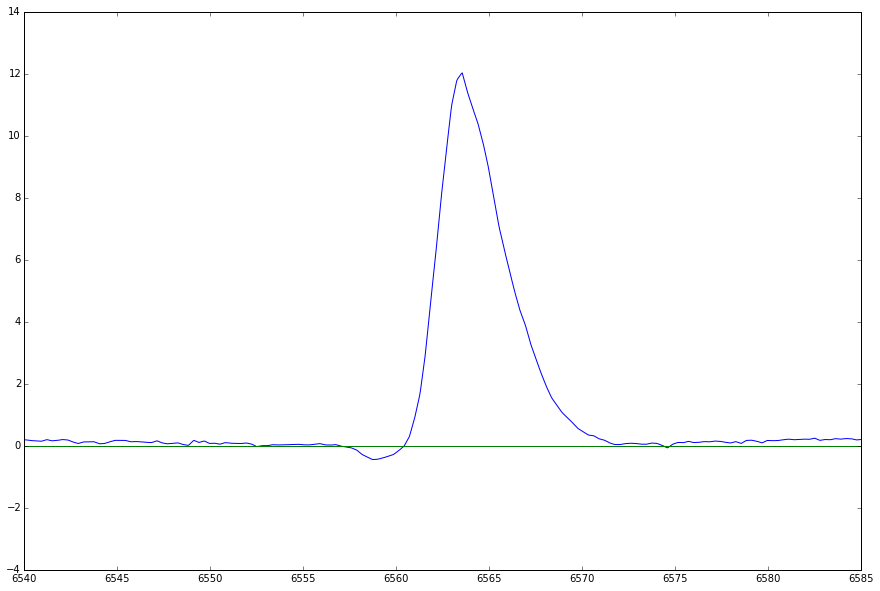

In [512]:
l=A[:,0]
x=A[:,1]
plt.figure(figsize=(15,10))
plt.plot(l,x-bbody(l,Teff,Aeff,Beff))
r=np.zeros(l.size)
plt.plot(l,r)
plt.xlim(6540,6585)

(-0.2, 1.1)

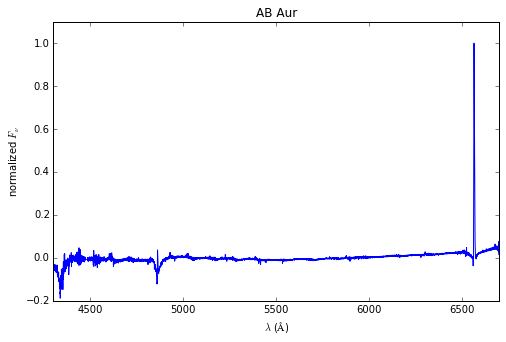

In [522]:
l=A[:,0]
x=A[:,1]
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4475
#lwfi=490
lwfi=4485
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4744
#lwfi=490
lwfi=4746
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5111
#lwfi=490
lwfi=5112
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5460
#lwfi=490
lwfi=5462
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5482
#lwfi=490
lwfi=5484
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))

plt.figure(figsize=(8,5))
plt.plot(l,(x-bbody(l,Teff,Aeff,Beff))/np.max(x-bbody(l,Teff,Aeff,Beff)))
plt.ylabel(r"normalized $F_\nu$")
plt.xlabel(r"$\lambda$ ($\AA$)")
plt.title("AB Aur")
plt.xlim(4300,6700)
plt.ylim(-0.2,1.1)

http://arxiv.org/pdf/astro-ph/0503507v2.pdf
http://www.star.ucl.ac.uk/~msw/thesis/chap6.pdf

In [402]:
def pcyg(l,mu1,sigma1,A1,mu2,sigma2,A2):
    gs1=A1*np.exp(-(l-mu1)**2/(2.*sigma1**2))
    gs2=-A2*np.exp(-(l-mu2)**2/(2.*sigma2**2))
    return gs1+gs2

[  8.54611754e-08  -1.60941881e-03   1.00818749e+01  -2.10029164e+04]


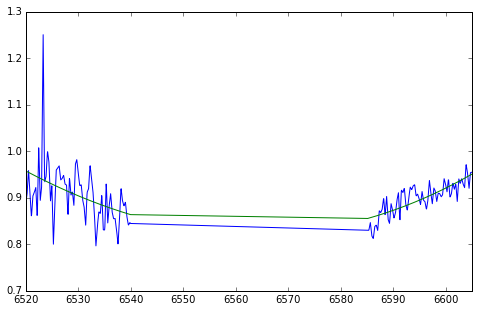

In [535]:
#6550-6575 es un ancho estándar para obtener el continuo
# da un mejor chi cuadrado que escogiendo un intervalo mas angosto para el continuo
l=A[:,0]
x=A[:,1]
lali=6540
lalf=6585
lin=6520
lfi=6605
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
x=np.concatenate((x[l<lali],x[l>lalf]))
l=np.concatenate((l[l<lali],l[l>lalf]))
contfit=np.polyfit(l,x,3)
plt.figure(figsize=(8,5))
plt.plot(l,x)
plt.plot(l,np.poly1d(contfit)(l))
plt.xlim(lin,lfi)
print contfit

[  6.56332441e+03   2.24809009e+00   1.20487909e+01   6.56090116e+03
   1.34968088e+00   6.19258139e+00]
Chi sq is 0.031070735637
Discrepancy 23


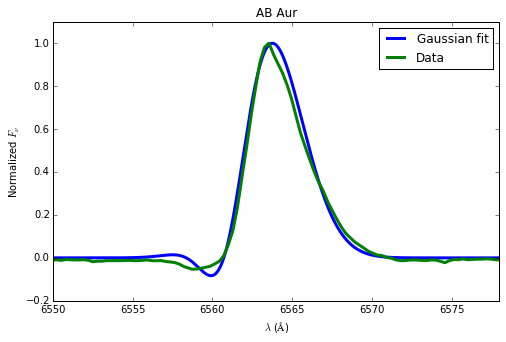

In [545]:
# este metodo da el menor chi2
l=A[:,0]
x=A[:,1]
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
xnorm=x-np.poly1d(contfit)(l)
par,pconv = curve_fit(pcyg, l, xnorm,p0=[6565.,2.,12.,6560.,1.,1.])
print par
plt.figure(figsize=(8,5))
plt.plot(l,pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5])/np.max(pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5])),linewidth=3.,label="Gaussian fit")
plt.plot(l,xnorm/np.max(xnorm),linewidth=3.,label="Data")
delt=(xnorm-pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))**2
print "Chi sq is", delt.sum()/x.size
plt.xlim(lin,lfi)
plt.ylabel(r"Normalized $F_\nu$")
plt.xlabel(r"$\lambda$ ($\AA$)")
plt.title("AB Aur")
plt.ylim(-0.2,1.1)
print "Discrepancy",np.argmin(pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))-np.argmin(xnorm)
plt.xlim(6550,6578)
plt.legend()

[  6.56332497e+03   2.26360139e+00   1.55860234e+01   6.56089880e+03
   1.34127630e+00   8.03377029e+00]
0.0626014898156
Discrepancy 23


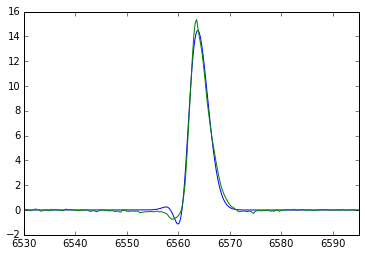

In [495]:
l=A[:,0]
x=A[:,1]
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
xnorm=x/np.poly1d(contfit)(l)-1
par,pconv = curve_fit(pcyg, l, xnorm,p0=[6565.,2.,12.,6560.,1.,1.])
print par
plt.plot(l,pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))
plt.plot(l,xnorm)
delt=(xnorm-pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))**2
print delt.sum()/x.size
plt.xlim(lin,lfi)
print "Discrepancy",np.argmin(pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))-np.argmin(xnorm)

[  1.02556621e-06  -2.00563665e-02   1.30736654e+02  -2.84051791e+05]


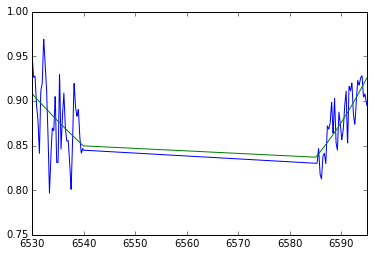

In [497]:
#esta ventana da un peor chi2
#6550-6575 es un ancho estándar para obtener el continuo
l=A[:,0]
x=A[:,1]
lali=6540
lalf=6585
lin=6530
lfi=6595
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
x=np.concatenate((x[l<lali],x[l>lalf]))
l=np.concatenate((l[l<lali],l[l>lalf]))
contfit=np.polyfit(l,x,3)
plt.plot(l,x)
plt.plot(l,np.poly1d(contfit)(l))
plt.xlim(lin,lfi)
print contfit

[  6.56332281e+03   2.26453919e+00   1.20683494e+01   6.56089635e+03
   1.34257084e+00   6.22640904e+00]
0.0379007949116
Discrepancy 23


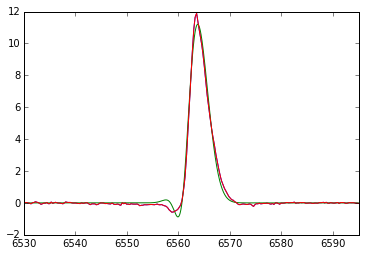

In [499]:
#norm- chi squared is lower than for norm/
l=A[:,0]
x=A[:,1]
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
xnorm=x-np.poly1d(contfit)(l)
plt.plot(l,xnorm)
plt.xlim(lin,lfi)
par,pconv = curve_fit(pcyg, l, xnorm,p0=[6565.,2.,12.,6560.,1.,1.])
print par
plt.plot(l,pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))
plt.plot(l,xnorm)
delt=(xnorm-pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))**2
print delt.sum()/x.size
print "Discrepancy",np.argmin(pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))-np.argmin(xnorm)

[  6.56332497e+03   2.26360139e+00   1.55860234e+01   6.56089880e+03
   1.34127630e+00   8.03377029e+00]
0.0626014898156
Discrepancy 23


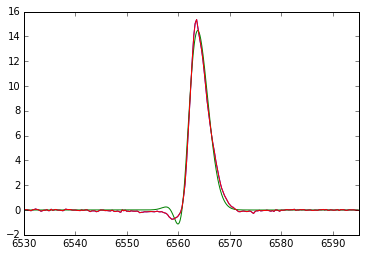

In [500]:
#norm/
l=A[:,0]
x=A[:,1]
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
xnorm=x/np.poly1d(contfit)(l)-1
plt.plot(l,xnorm)
plt.xlim(lin,lfi)
par,pconv = curve_fit(pcyg, l, xnorm,p0=[6565.,2.,12.,6560.,1.,1.])
print par
plt.plot(l,pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))
plt.plot(l,xnorm)
delt=(xnorm-pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))**2
print delt.sum()/x.size
print "Discrepancy",np.argmin(pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))-np.argmin(xnorm)

In [450]:
def gau(l,mu1,sigma1,A1):
    gs1=A1*np.exp(-(l-mu1)**2/(2.*sigma1**2))
    return gs1